In [1]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

# Imports all the libraries used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix
from umap import UMAP
from tqdm import tqdm
import cv2 as cv

from functools import partial

import jax
from jax import numpy as jnp
import haiku as hk
import optax

import resnet
import data
import train
import pickle

In [2]:
assert jax.local_device_count() >= 8, "TPUs not detected"

In [3]:
NUM_CLASSES = 4
SEED = 12
BATCH_SIZE = 128

jax.config.update("jax_debug_nans", False)
classes = ['Normal', 'Pneumonia-Bacterial', 'COVID-19', 'Pneumonia-Viral']

rng = jax.random.PRNGKey(SEED)

In [13]:
(x_train, y_train), (x_test, y_test) = data.load_data('.', rng, test_size = 0.1)

x_all = np.concatenate([x_test, x_train])
y_all = np.concatenate([y_test, y_train])

def forward(batch, is_training, return_representation = False, return_gradcam = False, gradcam_counterfactual = False):
    net = resnet.ResNet18(num_classes = NUM_CLASSES, resnet_v2 = True)
    if return_representation:
        return net.embedding(batch, is_training, embedding_depth=0)
    elif return_gradcam:
        return net.gradcam(batch, is_training, gradcam_depth=0, counterfactual=gradcam_counterfactual)
    else:
        return net(batch, is_training)

net = hk.transform_with_state(forward)
schedule = optax.cosine_decay_schedule(1e-1, 30 * (len(x_train) // BATCH_SIZE))
optim = optax.adamw(schedule, weight_decay = 1e-3)

# Gets functions for the model
init_fn, loss_fn, grad_fn, update, predict, evaluate, train_epoch = train.get_network_fns(net, optim, BATCH_SIZE, shape = (10, 256, 256, 3))

# Initializes parameters and state
params, state, optim_state = init_fn(rng)

# Train the model for 30 epochs
"""
for i in range(30):
    params, state, optim_state = train_epoch(params, state, optim_state, x_train, y_train, x_test, y_test)
"""

def load_model(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

loaded_model = load_model("checkpoints/basemodel_rgb.npy")
params = loaded_model[0]
state = loaded_model[1]
optim_state = loaded_model[2]

tcmalloc: large alloc 7241465856 bytes == 0x3f523c000 @  0x7f12080a7680 0x7f12080c8824 0x7f11fd6394ce 0x7f11fd68f00e 0x7f11fd68fc4f 0x7f11fd731924 0x5f2cc9 0x5f30ff 0x5705f6 0x568d9a 0x5f5b33 0x56bc9b 0x568d9a 0x5f5b33 0x56fb87 0x568d9a 0x5f5b33 0x56bc9b 0x568d9a 0x68cdc7 0x5ff5d4 0x5c3cb0 0x56aadf 0x501148 0x56c422 0x501148 0x56c422 0x501148 0x504d56 0x56acb6 0x5f5956
tcmalloc: large alloc 7241465856 bytes == 0x8951e000 @  0x7f12080a7680 0x7f12080c8824 0x7f12080c8b8a 0x7f0eea262c37 0x7f0eea2155eb 0x7f0eea2267a6 0x7f0eea2276dd 0x7f0ee6090b09 0x7f0ee60941a0 0x7f0ee9f42302 0x7f0ee763d220 0x7f0ee763d910 0x7f0ee7618e95 0x7f0ee761f686 0x7f0ee7621434 0x7f0ee52213bf 0x7f0ee4f9a9a8 0x7f0ee4f8a540 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369
tcmalloc: large alloc 7241465856 bytes == 0x243176000 @  0x7f12080a7680 0x7f12080c8824 0x7f12080c8b8a 0x7f0eea262c37 0x7f0eea2155eb 0x7f0eea2267a6 0x7f0eea2276dd 0x7f0ee6090b09 0x7f0ee6

In [14]:
import pickle

def save_model(filename):
    with open(filename, "wb") as f:
        pickle.dump((params, state, optim_state), f)

#save_model("checkpoints/basemodel_rgb.npy")

In [15]:
x_gradcam_data = x_test
y_gradcam_data = y_test

In [18]:
gradcam_batch_size = 8
datagen, num_batches = train.get_datagen(True, gradcam_batch_size, x_gradcam_data, y_gradcam_data, include_last = False)

# List with all the predictions
cams = []
counter_cams = []
# Applies the network to each batch
for x_batch, y_batch in tqdm(datagen()):
    apply = jax.pmap(net.apply, static_broadcasted_argnums = (2,4,5,6,7))

    c = apply(params, state, None, x_batch, True, False, True, False)[0]
    cc = apply(params, state, None, x_batch, True, False, True, True)[0]
    
    cams.append(c)
    counter_cams.append(cc)

cams = jnp.concatenate(cams)
counter_cams = jnp.concatenate(counter_cams)

115it [00:18,  6.20it/s]


In [39]:
y_pred = predict(params, state, x_gradcam_data, training=True)
y_pred.shape

100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.51s/it]


(920, 4)

[Text(0.5, 1.0, 'Original Results')]

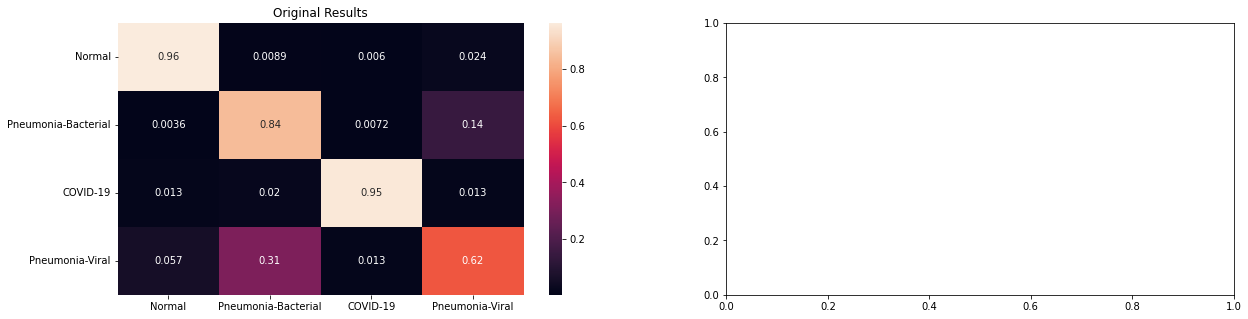

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
sn.heatmap(confusion_matrix(y_gradcam_data.argmax(1), y_pred.argmax(1), normalize = 'true'), ax = axs[0], annot = True, xticklabels = classes, yticklabels = classes).set(title = 'Original Results')

Perc correct 0.9613


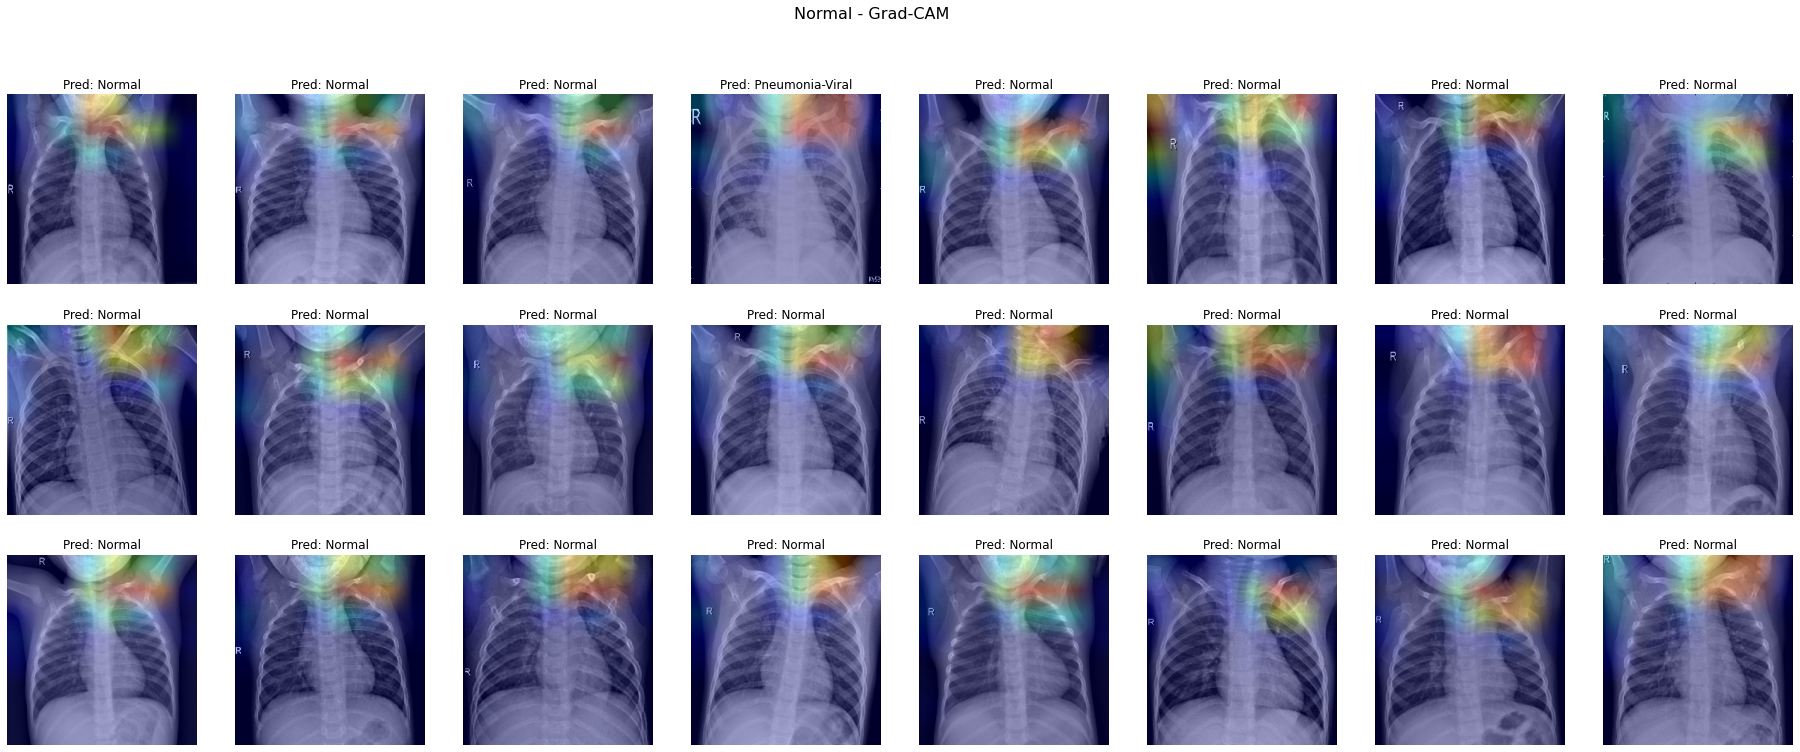

In [71]:
from IPython.display import Image, display
import matplotlib.cm as cm
import cv2
import utils

def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap /= heatmap.max()
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, dsize=(img.shape[0], img.shape[1]), interpolation=cv2.INTER_LINEAR)
    jet_heatmap /= jet_heatmap.max()
    jet_heatmap = np.clip(jet_heatmap, 0, 1)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img /= superimposed_img.max()
    # Display Grad CAM
    plt.imshow(superimposed_img)

CLASS_TO_DISPLAY = utils.CLASS_NORMAL
PREVIEW_CLASS = utils.CLASS_NORMAL
COUNTERFACTUAL = False

ROWS = 3
COLUMNS = 8
DISPLAY_RNG = jax.random.PRNGKey(987987689)

real = jnp.argmax(y_gradcam_data, axis=1)
predicted = jnp.argmax(y_pred, axis=1)
assert predicted.shape[0] == real.shape[0] and real.shape[0] == y_gradcam_data.shape[0]

indices_of_class = jnp.where(real == CLASS_TO_DISPLAY)[0]

print("Perc correct {:.4f}".format(jnp.mean((predicted[indices_of_class] == CLASS_TO_DISPLAY).astype(jnp.float32))))

indices_of_class = jax.random.choice(DISPLAY_RNG, indices_of_class, shape=[ROWS*COLUMNS], replace=False)

fig = plt.figure(figsize=(32, 12))
fig.suptitle(utils.CLASS_NAMES[CLASS_TO_DISPLAY] + (" - Grad-CAM" if not COUNTERFACTUAL else " - Counterfactual Grad-CAM"), fontsize=16)

for i in range(ROWS*COLUMNS):
    fig.add_subplot(ROWS, COLUMNS, i+1)

    img_index = indices_of_class[i]
    class_index = real[img_index]
    pred = predicted[img_index]
    img = x_all[img_index,]

    if not COUNTERFACTUAL:
        heatmap = cams[img_index, PREVIEW_CLASS, :, :]
    else:
        heatmap = counter_cams[img_index, PREVIEW_CLASS, :, :]

    display_gradcam(img, heatmap, alpha=0.5)

    title = "Pred: " + utils.CLASS_NAMES[pred]

    plt.title(title)
    plt.axis('off')

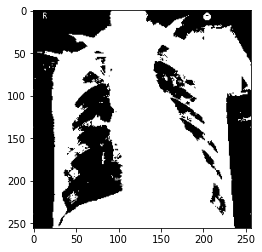

In [11]:
import cv2 as cv

img = np.array(x_train[0,:,:,:]).mean(axis=-1)
img = (img*255).astype(np.uint8)
#img = img.reshape(img.shape[0:2])
thresh, new_img = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

new_img = np.stack((new_img.reshape(new_img.shape[0:2]),)*3, axis=-1)
img = np.stack((img.reshape(img.shape[0:2]),)*3, axis=-1)

#plt.imshow(img)
plt.imshow(new_img)